## Predicting Loan Outcomes

In this project, we're going to analyze some lending data from [Lending Club](https://www.lendingclub.com/) to perform some credit modelling. Lending Club is a marketplace for personal loans that matches borrowers with investors. Each potential borrower completes an application, Lending Club evaluates the application, then assigns an interest rate. Investors are given some information from the application and can decide which to invest in. 

For this project, we will imagine we are a conservative investor. We want to limit our risk of the loans we invest in not being paid off. 

We should note at the beginning that lending has a [long history of discrimiation](https://www.investopedia.com/the-history-of-lending-discrimination-5076948) in the US. We will not get into those issues here but should be aware of them.  

## Data Set 
Lending Club used to release data on approved and declined loans on their website. They have stopped this practice but we will use a subset of data from 2007 to 2011, since most of these loans have been completed. You can find detailed information on what is included in the [data dictionary](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit?usp=sharing).

## Goal
Build a machine learning model that can accurately predict if a borrower will pay off their loan on time.


In [104]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    linewidth=4
    )


%matplotlib inline


In [15]:
loans = pd.read_csv('loans_2007.csv')

/Users/josh.fuchs/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [17]:
loans.shape

(42538, 52)

In [18]:
loans.dtypes

id                             object
member_id                     float64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                       object
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc    

## Data Cleaning

Before we build our ML model, we need to clean the data. Let's start by removing columns that leak information about the result of the loan, don't relate to the borrower's ability to pay off the loan, or contain redundant information. We carefully study the data dictionary to consider each column in turn.

Our target column is ```loan_status```. 

In [19]:
# the majority of the columns we drop are related to data leakage. 

columns_to_drop = ['id','member_id','funded_amnt','funded_amnt_inv',
                   'grade','sub_grade','emp_title','issue_d',
                  'zip_code','out_prncp','out_prncp_inv',
                   'total_pymnt','total_pymnt_inv','total_rec_prncp',
                   'total_rec_int','total_rec_late_fee',
                   'recoveries','collection_recovery_fee',
                   'last_pymnt_d','last_pymnt_amnt']

loans.drop(columns_to_drop,axis=1,inplace=True)

In [20]:
loans.shape

(42538, 32)

We dropped 20 columns, most of which are related to data leakage. Next, let's clean the target column. It contains text values we need to convert to numerical values for modelling. 

In [21]:
loans['loan_status'].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

We are interested in predicting whether or not loans will be paid off on time. This is a binary classification problem. Only ```Fully Paid``` and ```Charged Off``` describe the final outcomes of the loans. We're going to remove the other columns and transform these values to 0 or 1. Finally, we note we have quite a significant class imbalance. 33136 loans were fully paid while only 5634 loans were not paid off. We'll have to be careful with this for our modelling later. 

In [22]:
loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off')]

status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}

loans = loans.replace(status_replace)

Next, let's identify columns that only contain one unique value and remove them. They do not provide any helpful information for modelling. This leads us to dropping an additional 9 columns. 

In [23]:
drop_columns = []

for col in loans.columns:
    non_null = loans[col].dropna()
    unique_non_null = non_null.unique()
    length = len(unique_non_null)
    if length == 1:
        drop_columns.append(col)
        
loans.drop(drop_columns,axis=1,inplace=True)

print(drop_columns)

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


Now, let's start to work with the other columns to prepare them for modeling. Let's look at missing values and converting categorical columns to numeric. First, let's examine how many missing values we have left.

In [24]:
null_counts = loans.isnull().sum()

print(null_counts)

loan_amnt                  0
term                       0
int_rate                   0
installment                0
emp_length              1036
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64


In [25]:
print(loans.pub_rec_bankruptcies.value_counts(normalize=True,dropna=False))

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64


Most of the columns are not missing any values, which is great. ```emp_length``` is missing the most (1036), but this is an important column to keep for credit modelling. We see that ```pub_rec_bankreuptcies``` has very little variability, so we will drop it. Both ```title``` and ```revol_util``` are missing relatively few values, so we will just drop those rows. 

In [26]:
loans.drop(labels=['pub_rec_bankruptcies'],axis=1,inplace=True)

loans.dropna(axis=0,inplace=True)

print(loans.dtypes.value_counts())

object     11
float64    10
int64       1
dtype: int64


Now, let's deal with the object columns. We can pull these out to a new dataframe to work with first.

In [27]:
object_columns_df = loans.select_dtypes(include=['object'])

object_columns_df.head()

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016
1,60 months,15.27%,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Sep-2013
2,36 months,15.96%,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-2001,98.5%,Jun-2016
3,36 months,13.49%,10+ years,RENT,Source Verified,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016


Some of these columns seem like they represent categorial values. Let's start by checking some of these.

In [28]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']

for x in cols:
    print(loans[x].value_counts())

RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64
10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64
 36 months    28234
 60 months     9441
Name: term, dtype: int64
CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
AL     420
LA     420
KY     311
OK     285
UT     249
KS     249
AR     229
DC     209
RI     194
NM     180
WV     164
HI     162
NH     157
DE     110
MT      77
AK      76
WY      76
SD      60
VT  

The ```purpose``` and ```title``` columns appear to reflect similar information. Let's take a look at them to decide which one to keep.

In [29]:
print(loans['title'].value_counts())

print(loans['purpose'].value_counts())

Debt Consolidation         2068
Debt Consolidation Loan    1599
Personal Loan               624
Consolidation               488
debt consolidation          466
                           ... 
Refi Prior Loan               1
CARPET EXPENSE                1
golfer1                       1
debt consolidation #2         1
NEED HELP                     1
Name: title, Length: 18881, dtype: int64
debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64


```home_ownership```, ```verification_status```, ```emp_length```, and ```term``` each contain a few discrete categorical values. We can encode these columns as dummy variables. We'll keep the ```purpose``` column because it contains fewer categories and the ```title``` column contains some data quality issues. 

We'll drop ```title```, ```addr_state```, ```last_credit_pull_d```, and ```earliest_cr_line```. We can use a mapping dictionary to to transform the ```empl_length``` columns.

There are two columns (```int_rate``` and ```revol_util```) that need to be converted to numeric columns. 

In [30]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans.drop(labels=['last_credit_pull_d','addr_state','title',
                   'earliest_cr_line'],axis=1,inplace=True)

loans['int_rate'] = loans['int_rate'].str.rstrip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.rstrip('%').astype('float')

loans.replace(to_replace=mapping_dict,inplace=True)


In [31]:
dummy_df = pd.get_dummies(loans[['home_ownership',
                                 'verification_status',
                                 'purpose','term']])

loans = pd.concat([loans,dummy_df],axis=1)

loans.drop(['home_ownership',
             'verification_status',
             'purpose','term'],axis=1,inplace=True)

# Making Predictions

Now that we have cleaned and prepared the data, we are ready to build our model. We'll have to be particularly careful with the class imbalance of our target columns. 

Let's start by defining our error metric. We'll be predicting 0s and 1s, but accuracy is too simple a metric. False positives and false negatives affect us differently, we either lose money or miss out on making money. From a conversative investor point of view, we want to minimize our loses. Let's instead calculate the false positive rate and the true positive rate. We can look at these simultaneously to evaluate our model.

Let's start by defining the function we can use for our error metric.

In [33]:
def positivity_rates(predictions, actual_values):
    # False positives.
    fp_filter = (predictions == 1) & (actual_values == 0)
    fp = len(predictions[fp_filter])

    # True positives.
    tp_filter = (predictions == 1) & (actual_values == 1)
    tp = len(predictions[tp_filter])

    # False negatives.
    fn_filter = (predictions == 0) & (actual_values == 1)
    fn = len(predictions[fn_filter])

    # True negatives
    tn_filter = (predictions == 0) & (actual_values == 0)
    tn = len(predictions[tn_filter])

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return([tpr,fpr])

Now, let's build the model. We will want to include some cross-validation and we'll start with a logistic regression. This is a good first model for binary classification problems because it's quick and less prone to overfitting.

In [46]:
lr = LogisticRegression(max_iter=200)

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

lr.fit(loans[features],loans[target])

predictions = lr.predict(loans[features])

rates = positivity_rates(predictions,loans[target])
print(rates)

[0.9986681533791736, 0.9968454258675079]


In [45]:
lr = LogisticRegression(max_iter=200)

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

predictions = cross_val_predict(lr, loans[features],loans[target], cv=3)

predictions = pd.Series(predictions)
rates = positivity_rates(predictions,loans[target])
print(rates)


[0.9970175668589407, 0.9986179664363277]


/Users/josh.fuchs/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now that we have the basic models built, we need to first deal with the class imbalance. Let's try to deal with this by adjust the ```class_weight``` parameter.

In [44]:
lr = LogisticRegression(class_weight="balanced", max_iter=200)

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

predictions = cross_val_predict(lr, loans[features],loans[target], cv=3)

predictions = pd.Series(predictions)
rates = positivity_rates(predictions,loans[target])
print(rates)

[0.5120608285264814, 0.5032576505429418]


We lowerd both our false positive and true positve rates quite a lot. Unfortunately, they are still similar to each other. We would prefer the true positivity rate to be a little higher than the false positivity rate. Let's try increasing the penalty for misclassifying the negative class.


In [58]:
penalty = {
    0: 10,
    1: 1
}

lr = LogisticRegression(class_weight=penalty, max_iter=200)

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

predictions = cross_val_predict(lr, loans[features],loans[target], cv=3)

predictions = pd.Series(predictions)
rates = positivity_rates(predictions,loans[target])
print(rates)

[0.15521761929732564, 0.1504442250740375]


Increasing the penalty lowered both rates to around 15%. This lowers our overall risk, but comes as the expense of missing more true positives (borrowers we should have invested in). Let's try a few different penalty ratios to see how sensitive our rates are.



In [59]:
features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

rate_dict = {}

for x in range(11):
    penalty = {
        0: x,
        1: 1}
    
    lr = LogisticRegression(class_weight=penalty, max_iter=200)
    
    predictions = cross_val_predict(lr, loans[features],loans[target], cv=3)
    
    predictions = pd.Series(predictions)
    rates = positivity_rates(predictions,loans[target])
    rate_dict[x] = rates
    
print(rate_dict)

/Users/josh.fuchs/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{0: [1.0, 1.0], 1: [0.9970175668589407, 0.9986179664363277], 2: [0.9845634504457262, 0.9846001974333662], 3: [0.916917933927635, 0.9186574531095755], 4: [0.7880506030414264, 0.7901283316880553], 5: [0.6349632931305715, 0.6311944718657453], 6: [0.5056699003670687, 0.4918065153010859], 7: [0.40475878342947036, 0.39190523198420535], 8: [0.27874278972207656, 0.26870681145113523], 9: [0.21201494493969586, 0.19960513326752222], 10: [0.15521761929732564, 0.1504442250740375]}


In [62]:
plotting_dict = pd.DataFrame.from_dict(rate_dict,orient='index')

plotting_dict

,0,1
0,1.000000,1.000000
1,0.997018,0.998618
2,0.984563,0.984600
3,0.916918,0.918657
4,0.788051,0.790128
5,0.634963,0.631194
6,0.505670,0.491807
7,0.404759,0.391905
8,0.278743,0.268707
9,0.212015,0.199605


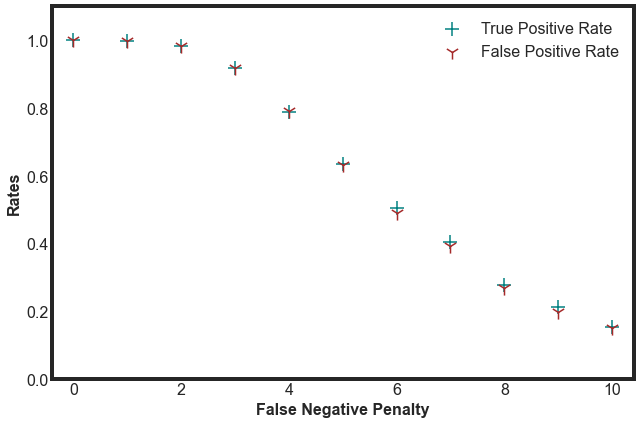

In [105]:
plt.figure(figsize=(9,6))

for key in rate_dict:
    plt.scatter(key,rate_dict[key][0],marker='+',c='teal',s=200)
    plt.scatter(key,rate_dict[key][1],marker='1',c='brown',s=200)
    
plt.xlabel('False Negative Penalty',fontsize=16)
plt.ylabel('Rates',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0,1.1)
plt.xlim(-0.4,10.4)

# points not on screen for legend
plt.scatter(-10,-10,marker='+',c='teal',s=200,label='True Positive Rate')
plt.scatter(-10,-10,marker='1',c='brown',s=200,label='False Positive Rate')

plt.legend(fontsize=16)
plt.show()

Let's try a slightly different approach and use a Random Forest Classifier. 

In [49]:
rf = RandomForestClassifier(class_weight="balanced")

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

predictions = cross_val_predict(rf, loans[features],loans[target], cv=3)

predictions = pd.Series(predictions)
rates = positivity_rates(predictions,loans[target])
print(rates)

[0.9959687991609858, 0.9950641658440277]


In [50]:
penalty = {
    0: 10,
    1: 1
}

rf = RandomForestClassifier(class_weight=penalty)

features = loans.columns.tolist()
features.remove('loan_status')

target = 'loan_status'

predictions = cross_val_predict(rf, loans[features],loans[target], cv=3)

predictions = pd.Series(predictions)
rates = positivity_rates(predictions,loans[target])
print(rates)

[0.9959360251704248, 0.9978282329713721]
